<a href="https://colab.research.google.com/github/valenlopez993/Cats_Dogs_Classifier/blob/main/Cat_Dog_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Getting the dataset

In [ ]:
try:
  !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

  !unzip cats_and_dogs.zip

  !rm -r __MACOSX
  !mkdir test_folder
  !mv test_folder cats_and_dogs/test
  !mv cats_and_dogs/test/*.jpg cats_and_dogs/test/test_folder

except:
  import subprocess

  def runCommand(command, verbose=True):
      process = subprocess.run(command, stdout = subprocess.PIPE, stderr = subprocess.PIPE, text = True, shell = True)
      std_out, std_err = process.stdout, process.stderr
      if verbose:
          print(std_out.strip(), std_err)

  runCommand('wget "https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip"')
  runCommand('tar -xf cats_and_dogs.zip')
  runCommand('rm -r __MACOSX')
  runCommand('mkdir test_folder')
  runCommand('mv test_folder cats_and_dogs/test')
  runCommand('mv cats_and_dogs/test/*.jpg cats_and_dogs/test/test_folder')

#Importing Keras and libraries

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

#A plot function to visuzlize the data

In [ ]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(len(images_arr) * 3, 5))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

#Preparing the data

In [ ]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1/255.0)
validation_image_generator = ImageDataGenerator(rescale=1/255.0)
test_image_generator = ImageDataGenerator(rescale=1/255.0)

train_data_gen = train_image_generator.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode='binary')
val_data_gen = train_image_generator.flow_from_directory(validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode='binary')
test_data_gen = train_image_generator.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb', batch_size=1, class_mode=None, shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


### Visualize 5 images from the data

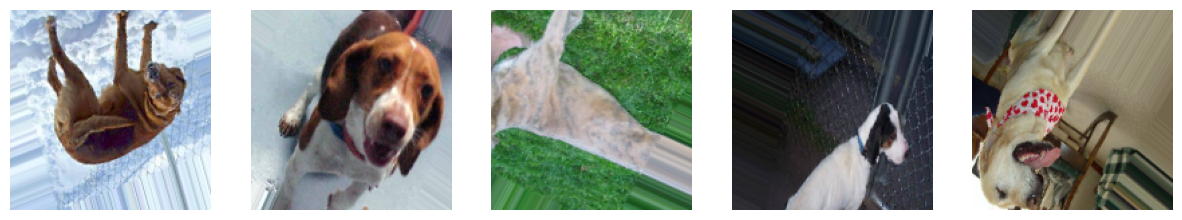

In [ ]:
sample_training_images, sample_training_labels = next(train_data_gen)
plotImages(sample_training_images[:5])

## Data augmentation for training

In [ ]:
train_image_generator = ImageDataGenerator( rescale=1/255.0,
                                            rotation_range=40,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            shear_range=0.2,
                                            zoom_range=0.2,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2)

train_data_gen = train_image_generator.flow_from_directory(train_dir, 
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode='rgb', 
                                                           batch_size=batch_size, 
                                                           class_mode='binary',
                                                           seed=42)

Found 2000 images belonging to 2 classes.


###Visualize 1 images after augmentation

(150, 150, 3)


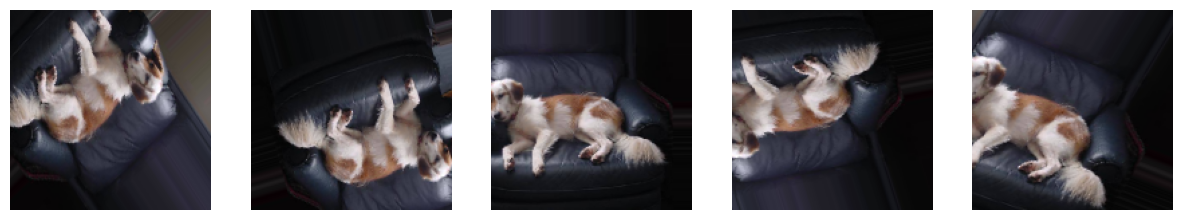

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#The Model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

##Training the model

In [ ]:
STEP_TRAIN = train_data_gen.__len__()
STEP_VALIDATION = val_data_gen.__len__()
history = model.fit(train_data_gen, 
                    validation_data=val_data_gen,
                    validation_steps=STEP_VALIDATION,
                    epochs=epochs,
                    steps_per_epoch=STEP_TRAIN) 

Epoch 1/20
16/16 [==============================] - 23s 1s/step - loss: 0.7733 - accuracy: 0.4935 - val_loss: 0.6899 - val_accuracy: 0.5090
Epoch 2/20
16/16 [==============================] - 21s 1s/step - loss: 0.6955 - accuracy: 0.5145 - val_loss: 0.6895 - val_accuracy: 0.6090
Epoch 3/20
16/16 [==============================] - 21s 1s/step - loss: 0.6904 - accuracy: 0.5415 - val_loss: 0.6787 - val_accuracy: 0.5030
Epoch 4/20
16/16 [==============================] - 20s 1s/step - loss: 0.6826 - accuracy: 0.5485 - val_loss: 0.6800 - val_accuracy: 0.5660
Epoch 5/20
16/16 [==============================] - 20s 1s/step - loss: 0.6682 - accuracy: 0.5835 - val_loss: 0.6521 - val_accuracy: 0.5710
Epoch 6/20
16/16 [==============================] - 19s 1s/step - loss: 0.6587 - accuracy: 0.5910 - val_loss: 0.6414 - val_accuracy: 0.6040
Epoch 7/20
16/16 [==============================] - 20s 1s/step - loss: 0.6402 - accuracy: 0.6240 - val_loss: 0.6208 - val_accuracy: 0.6460
Epoch 8/20
16/16 [==

##Performance of the model

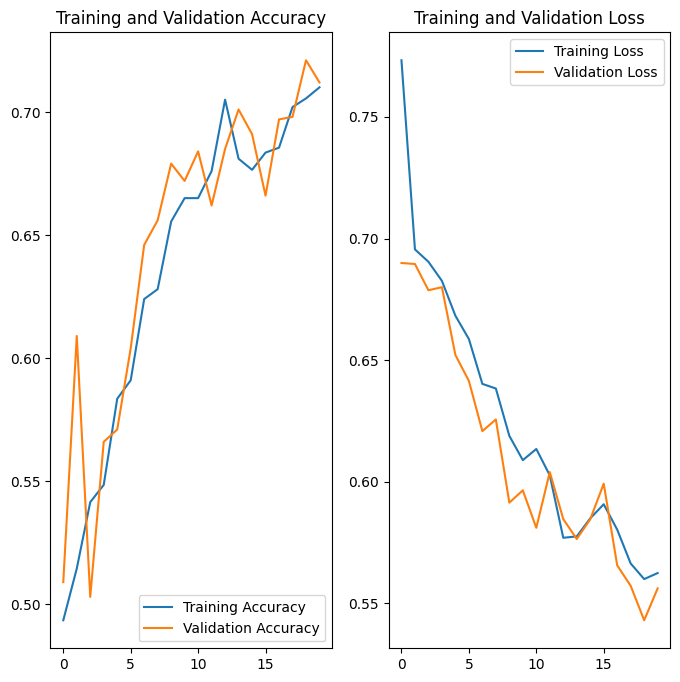

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Performing predictions

In [ ]:
prediction = model.predict(test_data_gen)

50/50 [==============================] - 0s 7ms/step


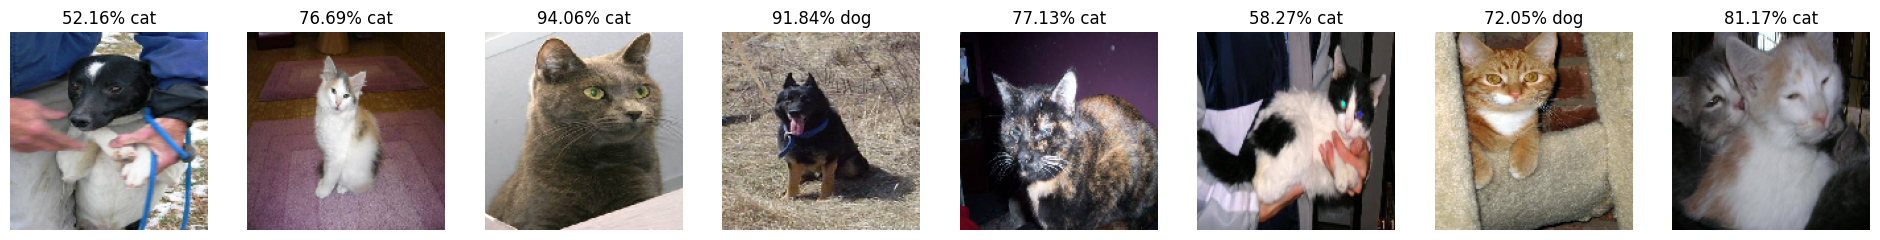

In [ ]:
probabilities = []
test_images = []

for result, test_data in zip(prediction, test_data_gen):
  probabilities.append(result[np.argmax(result)])
  test_images.append(test_data.reshape(IMG_HEIGHT, IMG_WIDTH, 3))

images2show = 8
plotImages(test_images[:images2show], probabilities[:images2show])


# Final Testing

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!
